### Imports

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from datetime import datetime
from copy import deepcopy
import torch
from torch.utils.data import Dataset
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.models import ResNet18_Weights
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score

### Loading dataset

In [2]:
pd_imgs = []
pr_imgs = []
cr_imgs = []
hlthy_imgs = []
all_imgs = []

PD_PATCHES_FOLDER = "binary_masks/PD-R1-NA-6-dapi-20a-telC-CERPNB-40x002-MaxIP - Stitched_patches"
PR_PATCHES_FOLDER = "binary_masks/PR-NA14-R1-dapi-20a-telC-cepnB-40x009-MaxIP - Stitched_patches"
CR_PATCHES_FOLDER_1 = "binary_masks/R1-CR-NA-12-dapi-20a-telc-cepnB-40x scan004-MaxIP - Stitched_patches"
CR_PATCHES_FOLDER_2 = "binary_masks/R1-CR-NA-12-dapi-20a-telC-cepnB-40x002-MaxIP - Stitched_patches"
HLTHY_PATCHES_FOLDER = "binary_masks/Smooth Muscle-NA-2-dapi-20a-telC-CEPRNB-40x-MaxIP - Stitched_patches"

for img_name in tqdm(os.listdir(PD_PATCHES_FOLDER)):
    img_path = os.path.join(PD_PATCHES_FOLDER, img_name)
    img = plt.imread(img_path)[:,:,0]
    if img.shape == (512, 512):
        pd_imgs.append(img)
        all_imgs.append(img)

for img_name in tqdm(os.listdir(PR_PATCHES_FOLDER)):
    img_path = os.path.join(PR_PATCHES_FOLDER, img_name)
    img = plt.imread(img_path)[:,:,0]
    if img.shape == (512, 512):
        pr_imgs.append(img)
        all_imgs.append(img)

for img_name in tqdm(os.listdir(CR_PATCHES_FOLDER_1)):
    img_path = os.path.join(CR_PATCHES_FOLDER_1, img_name)
    img = plt.imread(img_path)[:,:,0]
    if img.shape == (512, 512):
        cr_imgs.append(img)
        all_imgs.append(img)

for img_name in tqdm(os.listdir(CR_PATCHES_FOLDER_2)):
    img_path = os.path.join(CR_PATCHES_FOLDER_2, img_name)
    img = plt.imread(img_path)[:,:,0]
    if img.shape == (512, 512):
        cr_imgs.append(img)
        all_imgs.append(img)

for img_name in tqdm(os.listdir(HLTHY_PATCHES_FOLDER)):
    img_path = os.path.join(HLTHY_PATCHES_FOLDER, img_name)
    img = plt.imread(img_path)[:,:,0]
    if img.shape == (512, 512):
        hlthy_imgs.append(img)
        all_imgs.append(img)

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/812 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/588 [00:00<?, ?it/s]

### Spliting in train, val, test

In [3]:
X = np.array(all_imgs)
y = np.hstack([
    0*np.ones(len(pd_imgs)),
    1*np.ones(len(pr_imgs)),
    2*np.ones(len(cr_imgs)),
    3*np.ones(len(hlthy_imgs))
])

In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (1878, 512, 512), y_train: (1878,)
X_val: (627, 512, 512), y_val: (627,)
X_test: (627, 512, 512), y_test: (627,)


### Datasets

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32)
            image = image.unsqueeze(0)
        label = torch.tensor(label, dtype=torch.int64)

        return image, label

In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),                # Convert to PIL Image
    transforms.Resize((224, 224)),          # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),                  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

In [7]:
train_dataset = CustomImageDataset(X_train, y_train, transform=transform)
val_dataset = CustomImageDataset(X_val, y_val, transform=transform)
test_dataset = CustomImageDataset(X_test, y_test, transform=transform)

### Train function, Hyperparameters and Loading ResNet

In [8]:
def train_model(
        num_epochs, 
        model, 
        criterion,
        device, 
        optimizer,
        train_dataloader, 
        valid_dataloader, 
        curr_best_val_acc=0
):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    curr_best_val_acc = curr_best_val_acc
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_model = model

    for epoch in range(num_epochs):
        model.train()
        curr_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            curr_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        curr_train_loss /= len(train_dataloader)
        train_losses.append(curr_train_loss)
        train_accuracies.append(correct_train / total_train)

        model.eval()
        curr_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in valid_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                curr_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
            curr_val_loss /= len(valid_dataloader)
            val_losses.append(curr_val_loss)
            val_accuracies.append(correct_val / total_val)

        if val_accuracies[-1] > curr_best_val_acc:
            curr_best_val_acc = val_accuracies[-1]
            best_model = deepcopy(model)
            torch.save(model.state_dict(), f'resnets/resnet18_mask_{str(timestamp)}.pth')

        print(f"[{epoch+1}]/[{num_epochs}] --- Train loss : {curr_train_loss} --- Val loss : {curr_val_loss}")
        print(f"[{epoch+1}]/[{num_epochs}] --- Train acc : {train_accuracies[-1]} --- Val acc : {val_accuracies[-1]}")

    return best_model, train_losses, val_losses, train_accuracies, val_accuracies

In [9]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)

lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

In [10]:
best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    num_epochs,
    model,
    criterion,
    device,
    optimizer,
    train_dataloader,
    val_dataloader
)

[1]/[50] --- Train loss : 0.9994642007148872 --- Val loss : 0.9163378208875657
[1]/[50] --- Train acc : 0.5543130990415336 --- Val acc : 0.6092503987240829
[2]/[50] --- Train loss : 0.4925897116378202 --- Val loss : 0.9391039907932281
[2]/[50] --- Train acc : 0.8173588924387647 --- Val acc : 0.6076555023923444
[3]/[50] --- Train loss : 0.1907531905729892 --- Val loss : 1.0557422012090683
[3]/[50] --- Train acc : 0.9510117145899893 --- Val acc : 0.6076555023923444
[4]/[50] --- Train loss : 0.08051995816245927 --- Val loss : 1.2896073207259178
[4]/[50] --- Train acc : 0.9824281150159745 --- Val acc : 0.6060606060606061
[5]/[50] --- Train loss : 0.04569287162463544 --- Val loss : 1.203488352894783
[5]/[50] --- Train acc : 0.9877529286474973 --- Val acc : 0.620414673046252
[6]/[50] --- Train loss : 0.030437507737680513 --- Val loss : 1.1973835438489915
[6]/[50] --- Train acc : 0.9898828541001065 --- Val acc : 0.6395534290271132
[7]/[50] --- Train loss : 0.024365413373620328 --- Val loss : 

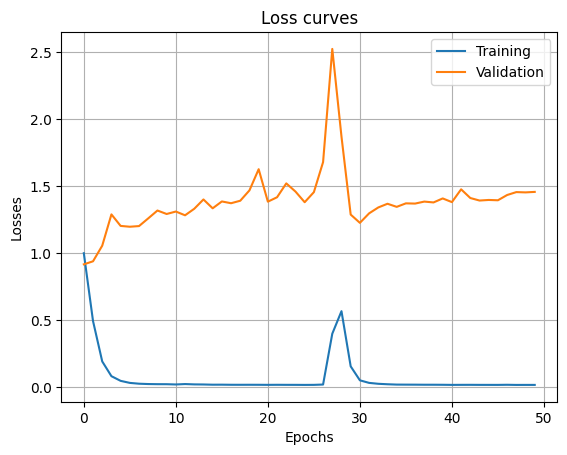

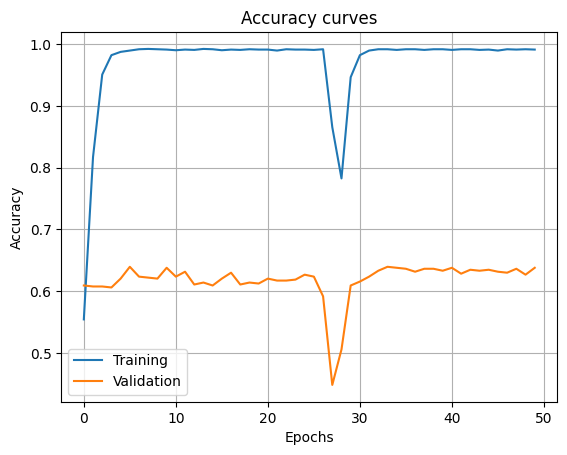

In [11]:
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Loss curves")
plt.legend()
plt.grid(1)
plt.show()


plt.plot(train_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy curves")
plt.legend()
plt.grid(1)
plt.show()

In [12]:
best_model.to(device)
best_model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Test Accuracy: 60.13%
Confusion Matrix:
[[ 66  34  42   4]
 [ 22  65  34  25]
 [ 27  22 158  20]
 [  4   9   7  88]]


In [13]:
classes = ['PD', 'PR', 'CR', 'HLTHY']
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, class_name in enumerate(classes):
    print(f"Accuracy for class {class_name}: {class_accuracies[i] * 100:.2f}%")

Accuracy for class PD: 45.21%
Accuracy for class PR: 44.52%
Accuracy for class CR: 69.60%
Accuracy for class HLTHY: 81.48%


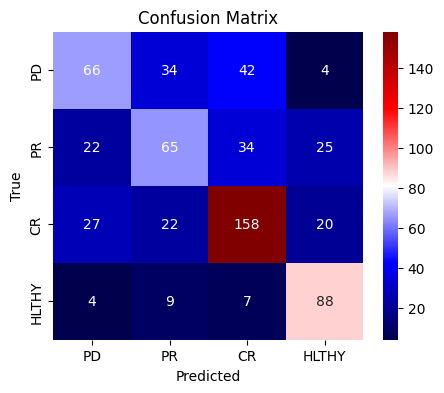

In [14]:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='seismic', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()